This uses German breast cancer dataset: which contains the expression levels of 76 genes, age, estrogen receptor status (er), tumor size and grade for 198 individuals. The objective is to predict the time to distant metastasis.

1
https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE7390

2
Desmedt, C., Piette, F., Loi et al.: “Strong Time Dependence of the 76-Gene Prognostic Signature for Node-Negative Breast Cancer Patients in the TRANSBIG Multicenter Independent Validation Series.” Clin. Cancer Res. 13(11), 3207–14 (2007)
https://aacrjournals.org/clincancerres/article/13/11/3207/193398/Strong-Time-Dependence-of-the-76-Gene-Prognostic



Other references to Survival analysis

For lung cancer
https://medium.com/analytics-vidhya/survival-analysis-with-python-69e51355d18
https://github.com/zahrael97/Predicting-lung-cancer-survival-time/blob/master/code/Data%20Exploration%20%2B%20Lifeline.ipynb

https://github.com/sherw98/SurvivalAnalysis/blob/master/Survival%20Analysis4.pdf

Some other breast cancer dataset (Fudan university)
https://pubmed.ncbi.nlm.nih.gov/35179504/
https://github.com/xiaojialong0518/ml-for-survival


Encoder/Decoder for dimensionality reduction
https://ekamperi.github.io/machine%20learning/2021/01/21/encoder-decoder-model.html


In [1]:
!pip install scikit-survival
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.2/31.2 MB 27.9 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.9/575.9 KB 4.7 MB/s eta 0:00:00


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

from sklearn.model_selection import train_test_split
from sksurv.datasets import load_breast_cancer
from sksurv.ensemble import ComponentwiseGradientBoostingSurvivalAnalysis
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder

In [2]:
data_x, data_y = load_breast_cancer()
X_t = OneHotEncoder().fit_transform(data_x)

X_train, X_test, y_train, y_test = train_test_split(X_t, data_y, test_size=0.25, random_state=0)

In [3]:
colnames = data_x.columns.to_list()

# Dimension reduction and handling of multi-modal data using an encoder / decoder deep learning network

Using an encoder-decoder to do dimensionality reduction on multi-modal data


In [4]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense
import random
from sklearn.preprocessing import StandardScaler

In [5]:
# Pre-processing.
# Convert data_x to numpy array
X_t_np = X_t.to_numpy()

# Scale data to have zero mean and unit variance
scaler = StandardScaler()
scaler.fit(X_t_np)
X_t_np = scaler.transform(X_t_np)

Build the auto-encoder.
We use a simple dense network as encoder with relu activation.
We use a simple dense network as decoder with relu activation in intermediate stage, and no activation in final stage so that we can compare with input.

Combine the encoder and decoder into an autoencoder, with MSE loss. Use Adam optimizer with default settings.

In [6]:
# Number of features of the original data
input_dim = X_t_np.shape[1]

# Number of features of the encoded data i.,e latent space
latent_dim = 10

encoder = Sequential([
    Dense(128, activation='relu', input_shape=(input_dim,)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(latent_dim, activation='relu')
])

decoder = Sequential([
    Dense(64, activation='relu', input_shape=(latent_dim,)),
    Dense(128, activation='relu'),
    Dense(256, activation='relu'),
    Dense(input_dim, activation=None)
])

autoencoder = Model(inputs=encoder.input, outputs=decoder(encoder.output))
autoencoder.compile(loss='mse', optimizer='adam')

Train the autoencoder over some epochs. 
It is important to note that the input and output are the same, because we want the autoencoder to reconstruct the original data.

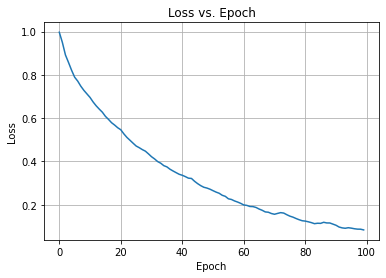

In [7]:
n_epochs = 100
model_history = autoencoder.fit(X_t_np, X_t_np, epochs=n_epochs, batch_size=16, verbose=0)

plt.plot(model_history.history["loss"])
plt.title("Loss vs. Epoch")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.grid(True)

In [8]:
# Plot different samples to visualize the loss.
def plot_orig_vs_recon(x_train, colnames, title='', n_samples=1):
    fig = plt.figure(figsize=(15,25))
    plt.suptitle(title)
    for i in range(n_samples):
        plt.subplot(3, 1, i+1)
        idx = random.sample(range(x_train.shape[0]), 1)
        plt.plot(autoencoder.predict(x_train[idx]).squeeze(), label='reconstructed' if i == 0 else '')
        plt.plot(x_train[idx].squeeze(), label='original' if i == 0 else '')
        fig.axes[i].set_xticklabels(colnames)
        plt.xticks(np.arange(0, len(colnames), 1), rotation=90)
        plt.grid(True)
        if i == 0: plt.legend();

1/1 [==============================] - 0s 197ms/step


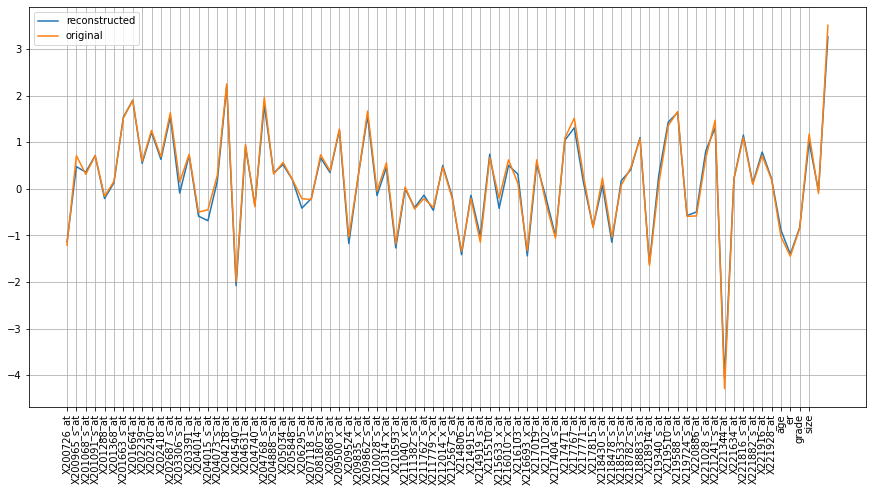

In [ ]:
# Plot a random sample to see how the encoded corresponds to the original.
plot_orig_vs_recon(X_t_np, colnames)

The reconstructed values are very close to the original. And the loss is low.

Now, to reduce the dimension of the original dataset before passing on to the survival modeling.

In [9]:
encoded_X_train = encoder(X_t_np)

## `Survival modeling`

 we are using gradient boosting on Cox’s partial likelihood with Gradient boosting trees. Concordance index is used to measure the quality of the model.

In [10]:
class EarlyStoppingMonitor:

    def __init__(self, window_size, max_iter_without_improvement):
        self.window_size = window_size
        self.max_iter_without_improvement = max_iter_without_improvement
        self._best_step = -1

    def __call__(self, iteration, estimator, args):
        # continue training for first self.window_size iterations
        if iteration < self.window_size:
            return False

        # compute average improvement in last self.window_size iterations.
        # oob_improvement_ is the different in negative log partial likelihood
        # between the previous and current iteration.
        start = iteration - self.window_size + 1
        end = iteration + 1
        improvement = np.mean(estimator.oob_improvement_[start:end])

        if improvement > 1e-6:
            self._best_step = iteration
            return False  # continue fitting

        # stop fitting if there was no improvement
        # in last max_iter_without_improvement iterations
        diff = iteration - self._best_step
        return diff >= self.max_iter_without_improvement


monitor = EarlyStoppingMonitor(25, 50)

In [11]:
est_cph_tree = GradientBoostingSurvivalAnalysis(
    n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0
)

# Original dataset.
# est_cph_tree.fit(X_train, y_train)
# cindex = est_cph_tree.score(X_test, y_test)
est_cph_tree.fit(X_t, data_y)
cindex = est_cph_tree.score(X_t, data_y)
print(f"Concordance Index Original = {round(cindex, 3)}")

# With dimensionality reduced inputs with only 10 latent features.
# est_cph_tree.fit(encoded_X_train, data_y)
# cindex = est_cph_tree.score(encoded_X_train, data_y)
# print(f"Concordance Index Compressed = {round(cindex, 3)}")

print(f"Estimator train score {est_cph_tree.train_score_[-1]}")

Concordance Index Original = 0.973
Estimator train score 150.2211055256156


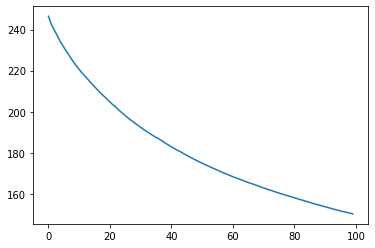

In [ ]:
plt.plot(est_cph_tree.train_score_)
plt.show()

Let’s see how the test performance changes with the ensemble size (n_estimators). We can in future do hyper-parameter tuning with a different library, optuna.

In [ ]:
scores_cph_tree = {}

est_cph_tree = GradientBoostingSurvivalAnalysis(
    loss="coxph", learning_rate=1.0, max_depth=1, random_state=42, verbose=0
)
for i in range(1, 50):
    n_estimators = i * 20
    est_cph_tree.set_params(n_estimators=n_estimators)
    est_cph_tree.fit(X_t, data_y)
    scores_cph_tree[n_estimators] = est_cph_tree.score(X_test, y_test)

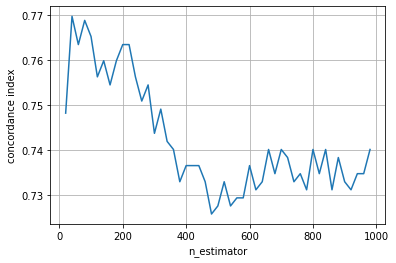

In [ ]:
x, y = zip(*scores_cph_tree.items())
plt.plot(x, y)
plt.xlabel("n_estimator")
plt.ylabel("concordance index")
plt.grid(True)

**The Survival Function**

A key quantity in survival analysis is the survival function, which relates time to the probability of surviving beyond a given time point.

Use Kaplan-Meier estimator for right-censored survival times

Text(0.5, 0, 'time $t$')

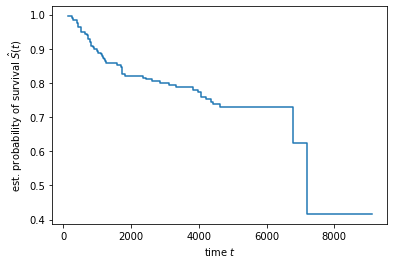

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator

time, survival_prob = kaplan_meier_estimator(data_y["e.tdm"], data_y["t.tdm"])
plt.step(time, survival_prob, where="post")
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")


The estimated curve is a step function, with steps occurring at time points where one or more patients died. From the plot we can see that most patients died after 6500 days days.

In [ ]:
list(data_x.columns)

Consider other variables by stratification.
Check the Stratification by

1.   Estrogen Receptor
2.   Grade



The obvious questions to ask is: > Is there any difference in survival between the two groups with different variables?

In [12]:
data_x["er"].value_counts()

positive    134
negative     64
Name: er, dtype: int64

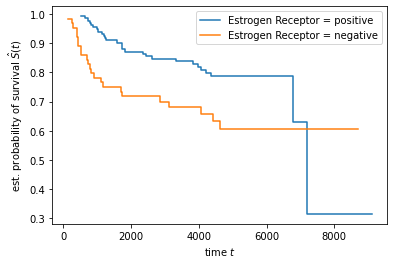

In [ ]:
for er in ("positive", "negative"):
    mask_treat = data_x["er"] == er
    time_er, survival_prob_er = kaplan_meier_estimator(
        data_y["e.tdm"][mask_treat],
        data_y["t.tdm"][mask_treat])

    plt.step(time_er, survival_prob_er, where="post",
             label="Estrogen Receptor = %s" % er)

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

In [16]:
data_x.describe()

,X200726_at,X200965_s_at,X201068_s_at,X201091_s_at,X201288_at,X201368_at,X201663_s_at,X201664_at,X202239_at,X202240_at,...,X221028_s_at,X221241_s_at,X221344_at,X221634_at,X221816_s_at,X221882_s_at,X221916_at,X221928_at,age,size
count,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,...,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000
mean,11.769030,10.502013,12.010590,10.052945,12.226866,11.885690,9.377997,10.082198,10.086569,7.438744,...,7.258468,6.887847,6.546925,7.469021,10.867050,9.136445,6.094197,7.078390,46.393939,2.181313
std,0.350226,0.844461,0.394151,0.598967,0.708435,0.681812,1.052047,0.833205,0.479510,1.097310,...,0.555002,1.227808,0.677002,0.713304,0.576539,0.765685,0.991772,1.221304,7.222101,0.804684
min,10.589865,7.780266,10.678572,7.362834,10.274986,9.977635,6.336848,7.478219,8.803921,4.399055,...,4.493046,3.419037,3.650357,3.905766,8.231835,6.805717,2.020037,3.814468,24.000000,0.600000
25%,11.552188,10.100334,11.780413,9.760231,11.848452,11.403981,8.647402,9.552538,9.768678,6.760160,...,6.948139,6.298955,6.299903,7.017298,10.560539,8.612117,5.677426,6.502075,42.000000,1.700000
50%,11.801067,10.564770,11.991386,10.076263,12.282309,11.928191,9.414460,10.153085,10.104199,7.517221,...,7.325968,7.123519,6.623371,7.443460,10.899565,9.135792,6.187649,7.145793,46.000000,2.000000
75%,11.998561,11.088772,12.250175,10.421905,12.735450,12.326101,10.100174,10.694771,10.370742,8.224308,...,7.637377,7.609037,6.980084,7.888287,11.292026,9.636698,6.703206,7.828096,51.000000,2.500000
max,12.539957,12.595082,12.998069,11.635007,14.012944,13.696713,11.915486,11.965807,11.849698,10.661379,...,8.391159,9.622886,7.742281,9.740692,12.137291,11.101291,8.743188,10.422690,60.000000,5.000000


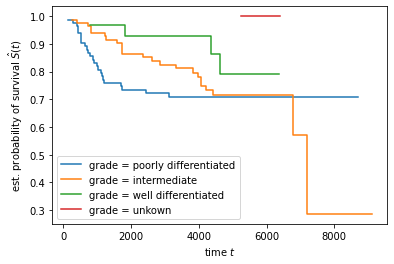

In [ ]:
from numpy.lib.twodim_base import vander
variable = "grade"
for var in list(data_x[variable].unique()):
    mask = data_x[variable] == var
    time_x, survival_prob_x = kaplan_meier_estimator(
        data_y["e.tdm"][mask],
        data_y["t.tdm"][mask])

    plt.step(time_x, survival_prob_x, where="post",
             label=f"{variable} = %s" % var)

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

# Understanding the effect of different variables and deriving personalized survival probabilities.



We can use a linear model Cox’s proportional hazard’s model, to estimate the impact each variable has on survival.
https://en.wikipedia.org/wiki/Proportional_hazards_model

We can compare this to a non-linear model using the Shapley score.

https://en.wikipedia.org/wiki/Shapley_value

https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html

https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/waterfall.html


In [ ]:
import shap

# Train the explainer model.
explainer = shap.Explainer(est_cph_tree.predict, X_train, feature_names=list(X_train.columns))

# Predict the results on the test data using the trained explainer model.
shaps = explainer(X_test)

Permutation explainer: 51it [00:27,  1.46it/s]


In [ ]:
# Print the first explanation just for demo purposes.
shap.plots.waterfall(shaps[0], max_display=20)

## Predicting a patient specific survival model

We use the fitted model to predict a patient specific survival function, by passing the test data to the predict_survival_function method.

In [ ]:
patient_id = 1
x_new = X_test.iloc[patient_id:patient_id+1, :]

In [ ]:
def predict_and_plot(est_cph_tree, x_new):
    pred_surv = est_cph_tree.predict_survival_function(x_new)

    # TODO, remove hardcoded range of time points. This should be taken from min and max of dataset.
    time_points = np.arange(125, 7185)
    for i, surv_func in enumerate(pred_surv):
        plt.step(time_points, surv_func(time_points), where="post",
             label="Sample %d" % (i + 1))
    plt.ylabel("est. probability of survival $\hat{S}(t)$")
    plt.xlabel("time $t$")
    plt.legend(loc="best")
    plt.show()

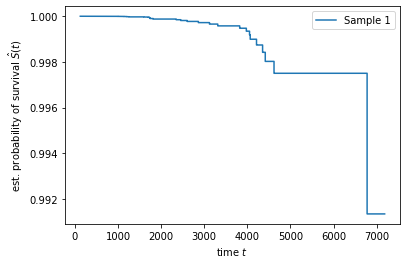

In [ ]:
predict_and_plot(est_cph_tree, x_new)

In [ ]:
# Print the first explanation just for demo purposes.
shaps = explainer(x_new)
shap.plots.waterfall(shaps[0], max_display=20)

### Find the important features

Show feature importance in a bar plot (Faster)

Show permutation importance in a box plot with the mean value (Slow).

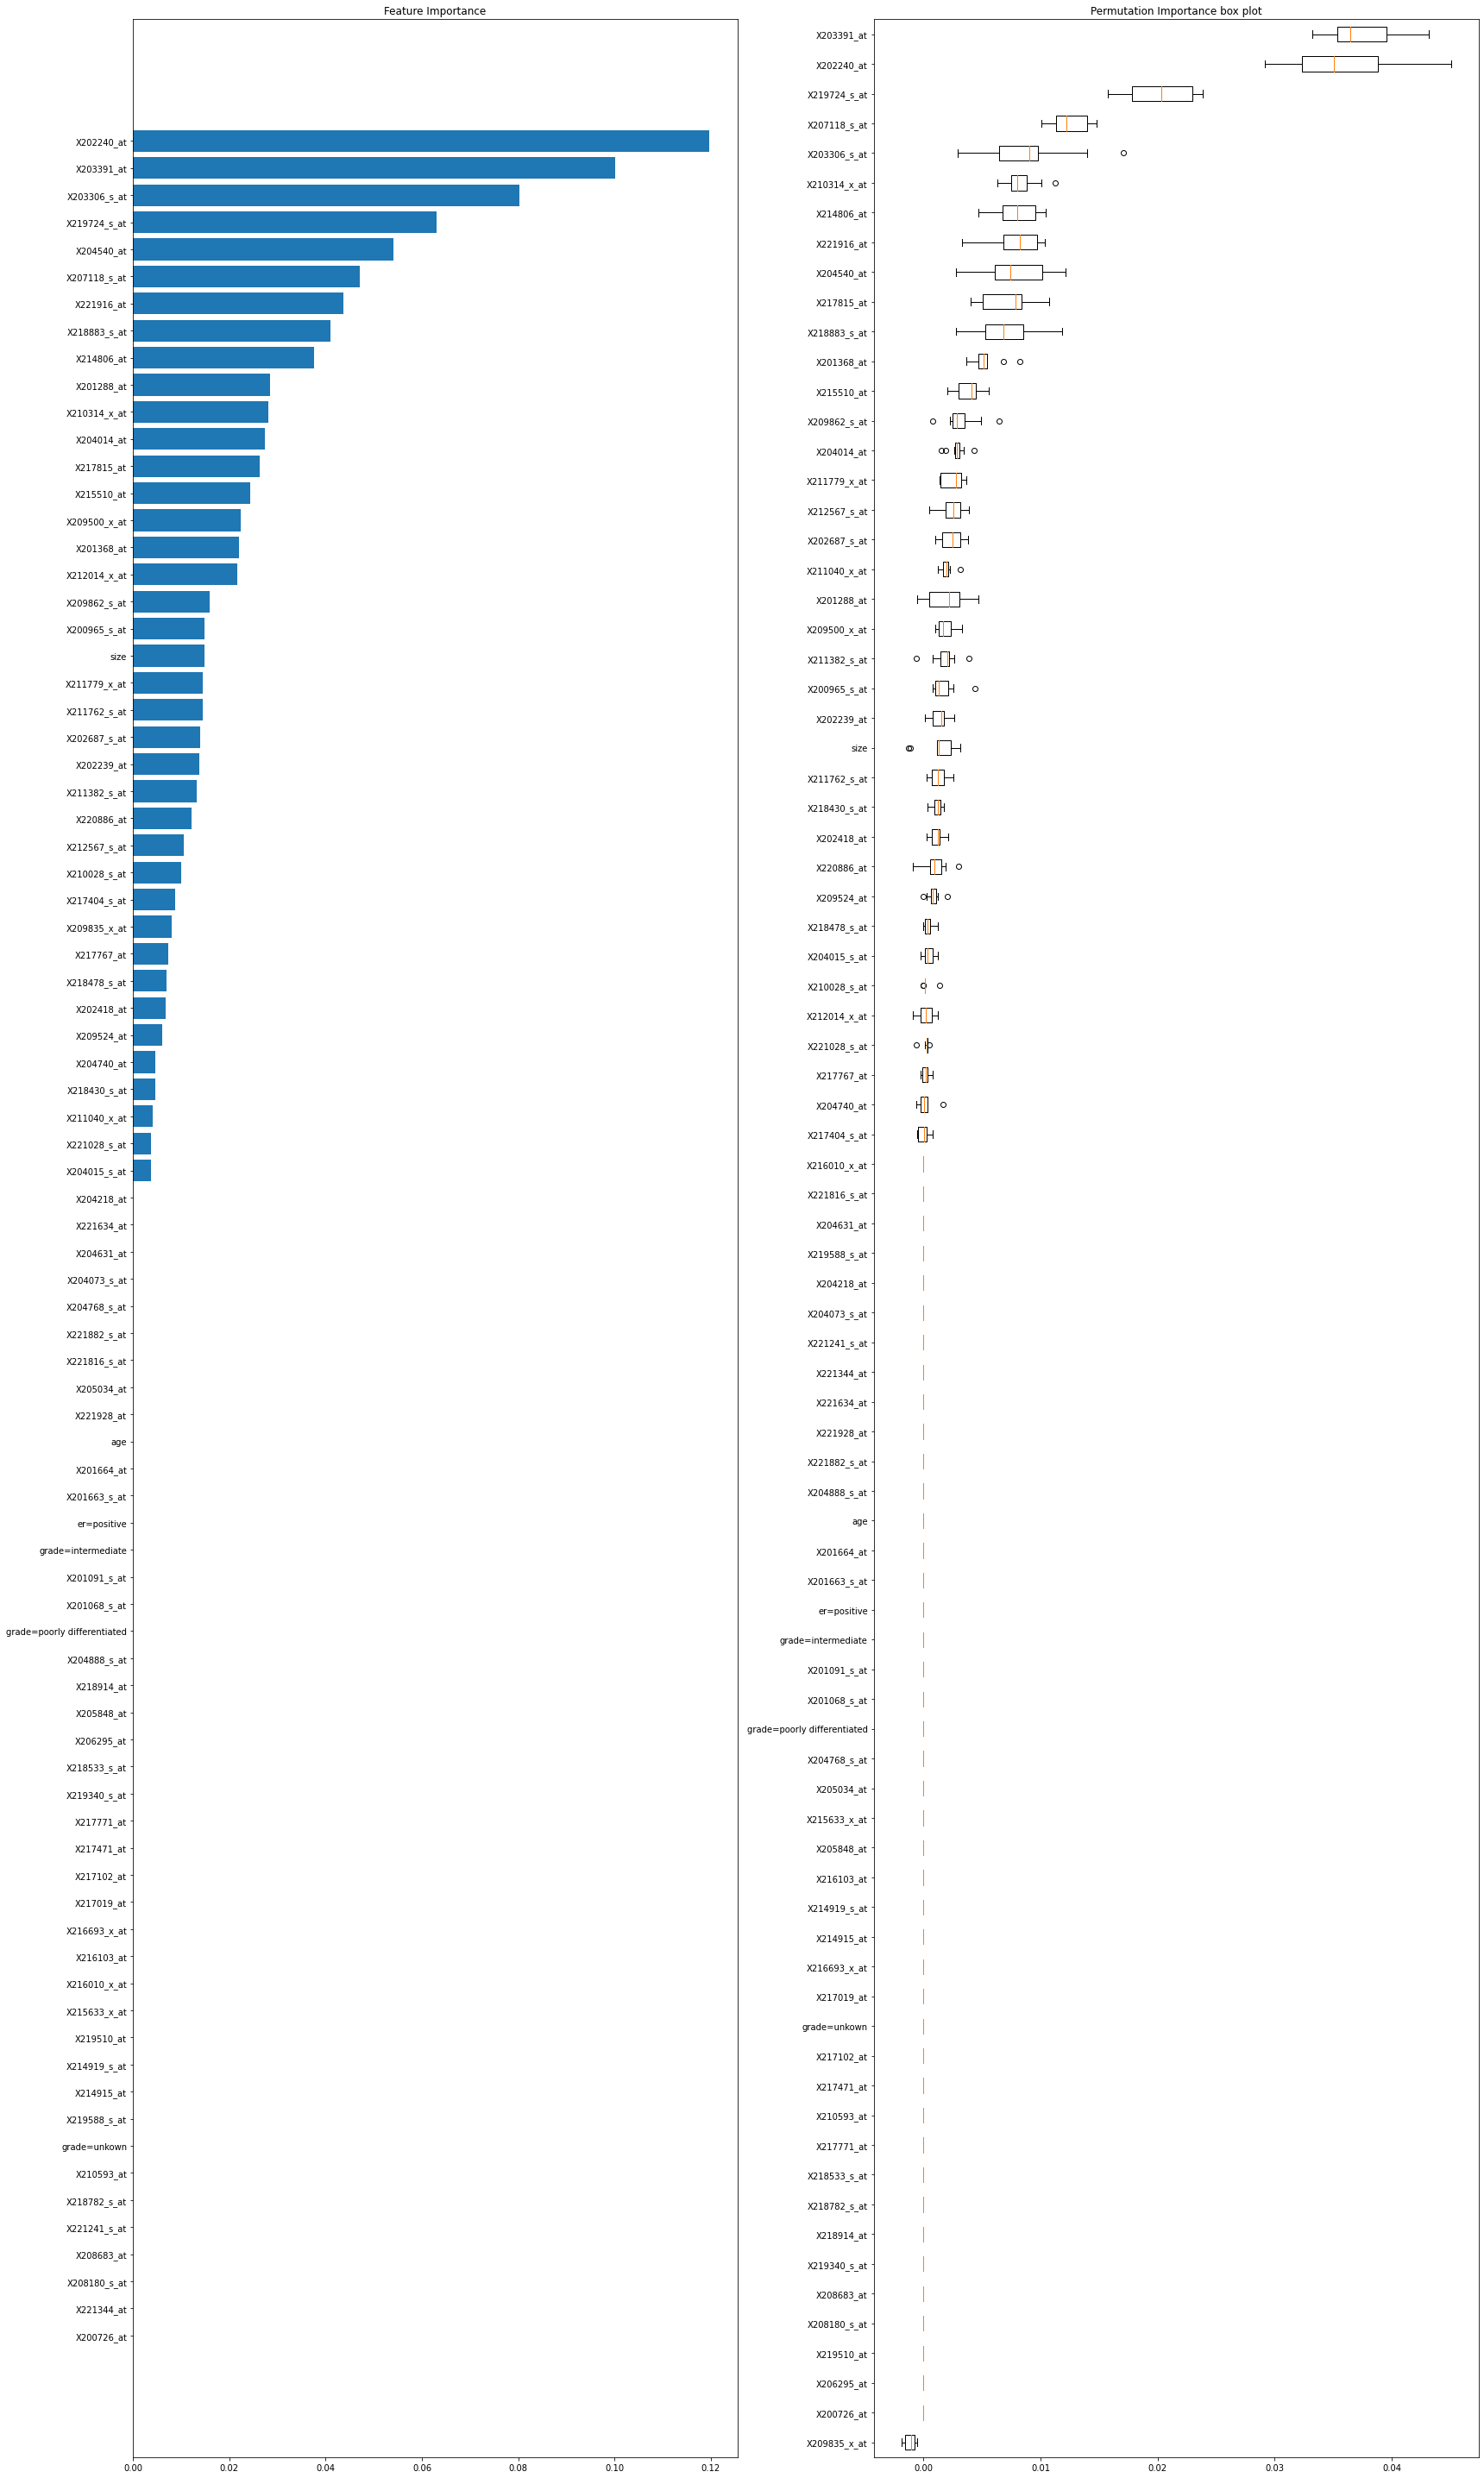

In [ ]:
feature_importance = est_cph_tree.feature_importances_
feature_names = list(X_t.columns)
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(24, 40))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(feature_names)[sorted_idx])
plt.title("Feature Importance")

from sklearn.inspection import permutation_importance
permutation_i_result = permutation_importance(
    est_cph_tree, X_t, data_y, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = permutation_result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feature_names)[sorted_idx],
)
plt.title("Permutation Importance box plot")
fig.tight_layout()
plt.show()

In [ ]:
# Top 25 important features
top_n = 25
pd.DataFrame(
    {k: result[k] for k in ("importances_mean", "importances_std",)},
    index=X_t.columns
).sort_values(by="importances_mean", ascending=False).head(top_n)

,importances_mean,importances_std
X203391_at,0.037470,0.003427
X202240_at,0.035728,0.004480
X219724_s_at,0.020250,0.002951
X207118_s_at,0.012486,0.001546
X203306_s_at,0.009039,0.003941
X210314_x_at,0.008383,0.001351
X214806_at,0.008029,0.001737
X221916_at,0.007991,0.002099
X204540_at,0.007941,0.002796
X217815_at,0.007133,0.002032


In [ ]:
X_t[["X203391_at"]].describe()

,X203391_at
count,198.000000
mean,10.415037
std,0.610213
min,8.607188
25%,10.062080
50%,10.460425
75%,10.835542
max,11.876375


In [ ]:
X_t.describe().loc[["min", "max"]]

,X200726_at,X200965_s_at,X201068_s_at,X201091_s_at,X201288_at,X201368_at,X201663_s_at,X201664_at,X202239_at,X202240_at,...,X221816_s_at,X221882_s_at,X221916_at,X221928_at,age,er=positive,grade=intermediate,grade=poorly differentiated,grade=unkown,size
min,10.589865,7.780266,10.678572,7.362834,10.274986,9.977635,6.336848,7.478219,8.803921,4.399055,...,8.231835,6.805717,2.020037,3.814468,24.0,0.0,0.0,0.0,0.0,0.6
max,12.539957,12.595082,12.998069,11.635007,14.012944,13.696713,11.915486,11.965807,11.849698,10.661379,...,12.137291,11.101291,8.743188,10.422690,60.0,1.0,1.0,1.0,1.0,5.0


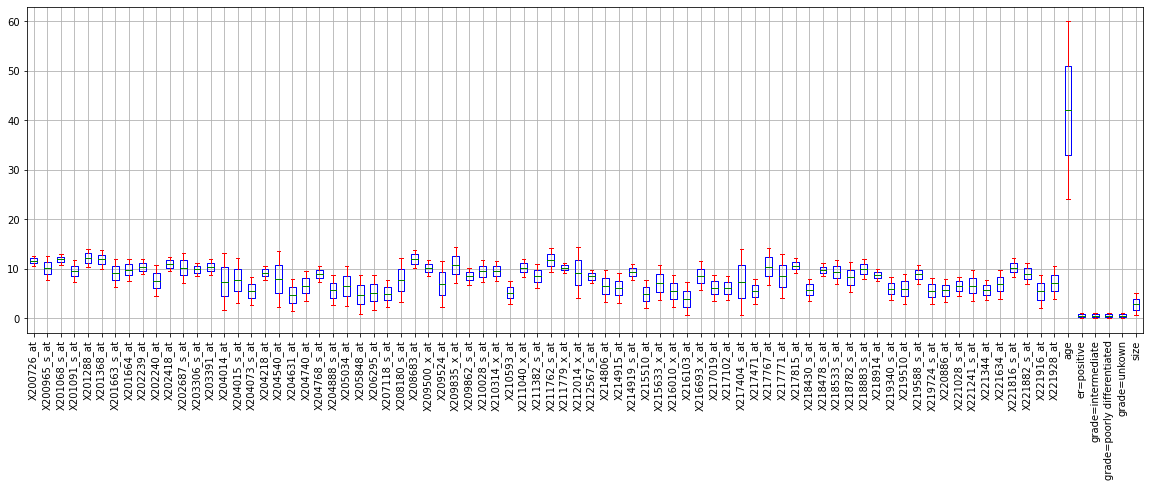

In [ ]:
# Print box plot showing the spread of each feature.
# Refer: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.boxplot.html
X_t.describe().loc[["min", "max"]].boxplot(figsize=(20,6), rot=90, color=dict(boxes='b', whiskers='r', medians='g', caps='r'))
plt.show()

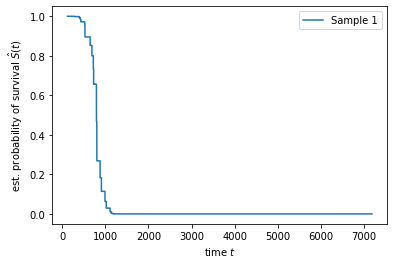

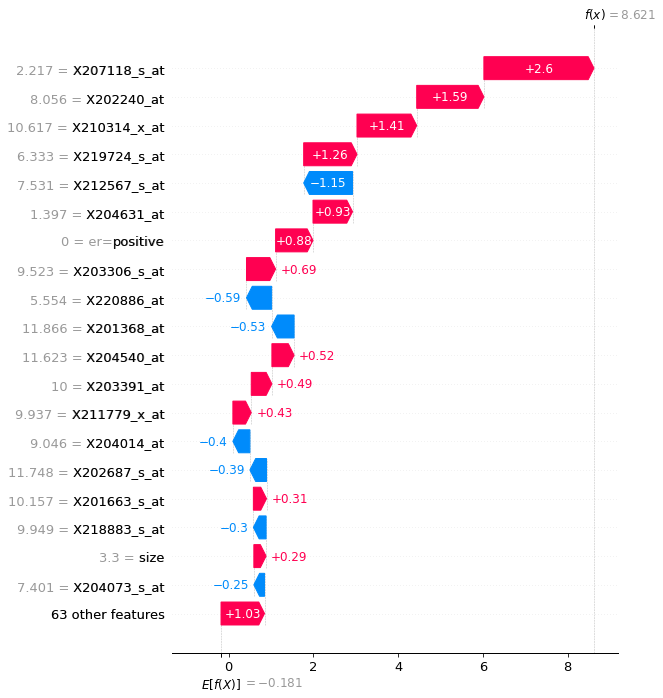

In [ ]:
## Start with a random sample
x_new = X_test.sample(n=1)

# Replace some properties
x_new["age"] = 10
x_new["size"] = 3.3
x_new["er=positive"] = 0
x_new["X203391_at"] = 10
x_new["grade=intermediate"] = 1

# Plot survival curve
predict_and_plot(est_cph_tree, x_new)

# Print the explanation.
shaps = explainer(x_new)
shap.plots.waterfall(shaps[0], max_display=20)